In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 0+untagged.1.g14e7b69
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: bayesian_exploration
  optim: {num_restarts: 1, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq:
    proximal_lengthscales: [1.5, 1.5]
    use_transformed_proximal_weights: true
    monte_carlo_samples: 128
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 5
  use_cuda: false
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE}
  constants: {a: dummy_constant}
  li

In [3]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,0.870203,1.371675,dummy_constant,0.870203,1.371675,1.731633,0.896867,"[1, 2, 3]",0.000059,False
2,0.284158,0.731564,dummy_constant,0.284158,0.731564,-0.477821,0.100210,"[1, 2, 3]",0.000014,False
3,1.034885,1.815428,dummy_constant,1.034885,1.815428,3.408972,2.016453,"[1, 2, 3]",0.000010,False
4,1.038441,1.366101,dummy_constant,1.038441,1.366101,2.000736,1.040049,"[1, 2, 3]",0.000009,False
5,1.657959,1.235953,dummy_constant,1.657959,1.235953,3.344284,1.882496,"[1, 2, 3]",0.000009,False
6,0.622339,1.061409,dummy_constant,0.622339,1.061409,0.572888,0.330147,"[1, 2, 3]",0.000042,False
7,0.893214,0.248617,dummy_constant,0.893214,0.248617,-0.104299,0.217811,"[1, 2, 3]",0.000041,False
8,0.039267,1.067537,dummy_constant,0.039267,1.067537,0.057987,0.534373,"[1, 2, 3]",0.000042,False
9,0.036208,1.069975,dummy_constant,0.036208,1.069975,0.060450,0.539974,"[1, 2, 3]",0.000041,False
10,0.318812,1.073991,dummy_constant,0.318812,1.073991,0.264622,0.362295,"[1, 2, 3]",0.000040,False


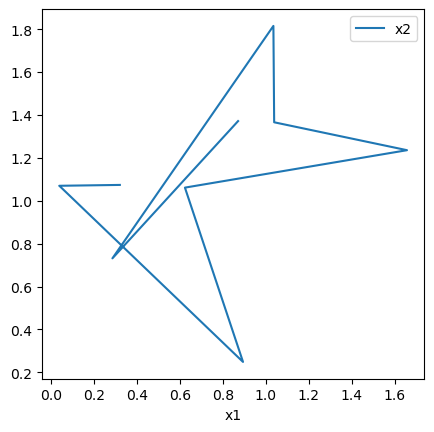

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

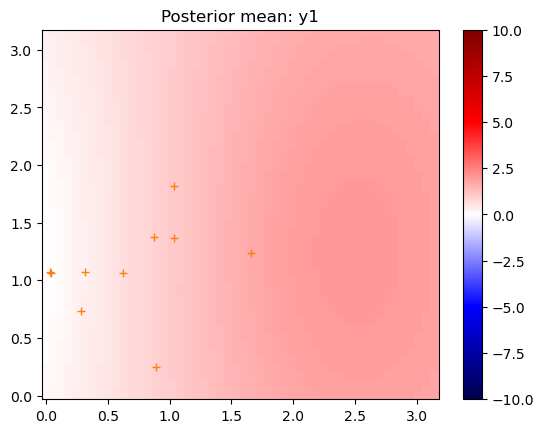

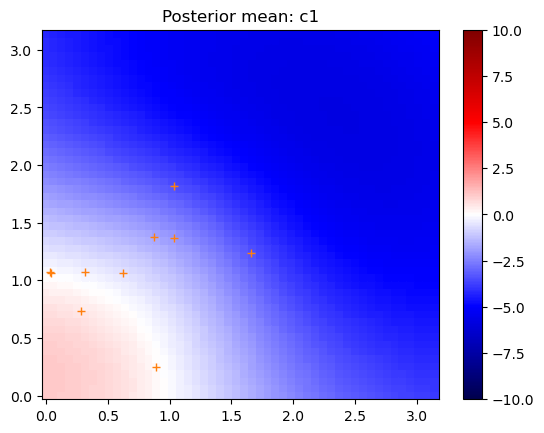

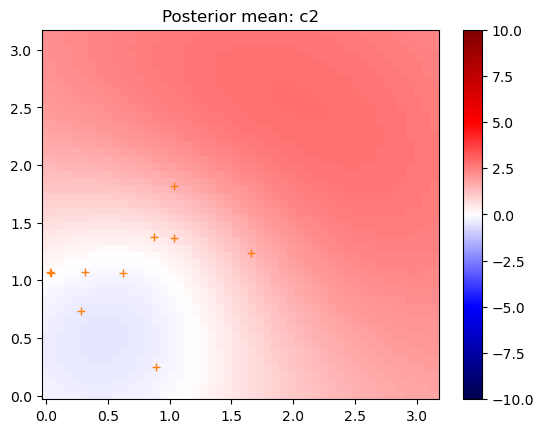

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(X.vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

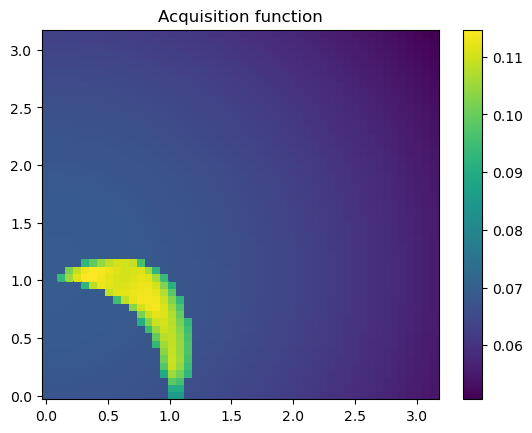

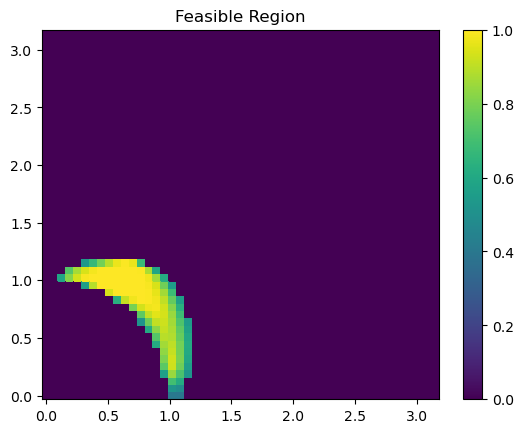

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")